In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Deep Learningドリル - Chainer記法編 -

前章ではChainerを使ってDeep Learningの基本について学びました。学習の反復については、そこそこ面倒に思われた方もいらっしゃると思います。前章で取り上げたような典型的な問題は誰が書いても同じようになります。何度も同じようなコードを書くことはコストの無駄とも言えますから、このような典型的な学習ルーチンをもっと簡単に書くためのヘルパーユーティリティがchainerには付属しています。この章では前回と同じ例題をchainerらしく書く方法について学びましょう。

## 例題（再掲）

あなたの務める会社では、スマートフォンを使った高齢者見守りアプリの開発を進めています。

スマートフォンには様々なセンサーが付いているため、これらの情報を使って、高齢者のより詳細な行動を取得するプロジェクトが開始されました。

センサーの情報から、「寝ている」「座った」「立ち上がった」「歩いた」「登った」「降った」の6カテゴリに分類するモデルを学習してください。

## 事前準備: データの読み込み

まずは実験に使うデータを読み込みましょう。

In [2]:
import numpy as np
import pandas as pd

In [3]:
np.random.seed(151)

In [4]:
train = pd.read_csv("data/train.csv")
dev = pd.read_csv("data/dev.csv")
test = pd.read_csv("data/test.csv")

## モデルの実装

それではモデルを実装します。前回と同じモデルですので説明は省略します。

In [5]:
import chainer.links as L
import chainer.functions as F

chainerに用意されているLinkとFunctionを組み合わせて、モデル(ネットワーク)を実装しましょう。chainerではこのモデルのことをchainと呼びます。

In [6]:
from chainer import Chain

In [7]:
class Model(Chain):
    def __init__(self):
        super(Model, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(561, 10)
            self.l2 = L.Linear(10, 8)
            self.l3 = L.Linear(8, 6)
    
    def __call__(self, x):
        h = self.l1(x)
        h = F.sigmoid(h)
        h = self.l2(h)
        h = F.sigmoid(h)
        return self.l3(h)

In [8]:
model = Model()

## データの整形

同様に前処理を行います。

In [9]:
activity_type = train["Activity"].unique()

In [10]:
activity_to_id = dict(zip(activity_type, np.arange(activity_type.shape[0])))

In [11]:
train_X = train.drop(["subject", "Activity"], axis=1)
train_Y = train["Activity"].map(lambda x: activity_to_id[x])

dev_X = dev.drop(["subject", "Activity"], axis=1)
dev_Y = dev["Activity"].map(lambda x: activity_to_id[x])

test_X = test.drop(["subject", "Activity"], axis=1)
test_Y = test["Activity"].map(lambda x: activity_to_id[x])

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()

In [14]:
train_X_scale = scaler.fit_transform(train_X)
dev_X_scale = scaler.transform(dev_X)
test_X_scale = scaler.transform(test_X)

In [15]:
train_Y = train_Y.values
dev_Y = dev_Y.values
test_Y = test_Y.values

In [16]:
train_X_scale = train_X_scale.astype(np.float32)
dev_X_scale = dev_X_scale.astype(np.float32)
test_X_scale = test_X_scale.astype(np.float32)
train_Y = train_Y.astype(np.int32)
dev_Y = dev_Y.astype(np.int32)
test_Y = test_Y.astype(np.int32)

## モデル学習

ここまでは前回と同じです。それではchainerらしい学習のコードを書いていきましょう。

In [17]:
from chainer import Variable
from chainer.optimizers import SGD
from chainer.datasets import TupleDataset
from chainer.iterators import SerialIterator
from chainer.training import StandardUpdater
from chainer.training import Trainer

まず、データから直接lossを計算するオブジェクトを用意します。chainerにはClassifierというクラスが用意されています。

In [18]:
classifier = L.Classifier(model)

classifierに対して、データと正解データを入力するとlossを計算します。試しに一つ計算してみましょう。

In [19]:
classifier(train_X_scale[:1], train_Y[:1])

variable(1.8243331909179688)

このコードは、
y = model(train_X_scale[:1])
F.softmax_cross_entropy(y, train_Y[:1])
と書いたのと同じ処理を行っています。コードが少しだけ短くなりましたね。

次にoptimizerを用意します。

In [21]:
optimizer = SGD()
optimizer.setup(classifier)

データセットを用意します。これは、XとYの値を組み合わせてくれる便利なツールです。

In [22]:
train_dataset = TupleDataset(train_X_scale, train_Y)
dev_dataset = TupleDataset(dev_X_scale, dev_Y)
test_dataset = TupleDataset(test_X_scale, test_Y)

たとえば、train_dataset[0]を実行すると、(Xの0番目, yの0番目)という内容のtupleが得られます。

次に、Iteratorを用意します。これは、データセットの中から順にデータを取り出すためのツールです。

In [23]:
train_iterator = SerialIterator(train_dataset, batch_size=100, repeat=True)
dev_iterator = SerialIterator(dev_dataset, batch_size=100, shuffle=False, repeat=False)
test_iterator = SerialIterator(test_dataset, batch_size=100, shuffle=False, repeat=False)

In [24]:
next(train_iterator)

[(array([ -2.92855315e-04,   2.29110450e-01,   5.87865770e-01,
          -7.86554873e-01,  -7.67838001e-01,  -4.30631429e-01,
          -8.04161489e-01,  -7.55713880e-01,  -3.76209736e-01,
          -7.13864148e-01,  -7.50302851e-01,  -4.71323639e-01,
           6.87789500e-01,   7.43167460e-01,   5.29299676e-01,
          -7.18638897e-01,  -6.90815330e-01,  -7.67922759e-01,
          -5.82667947e-01,  -8.04632604e-01,  -6.91224754e-01,
          -2.57405668e-01,  -3.29925239e-01,   7.23578259e-02,
           7.01858461e-01,   7.47727156e-01,  -9.83064249e-02,
          -2.49846175e-01,   1.53364146e+00,  -3.09055686e-01,
          -1.50582030e-01,   6.73045367e-02,   4.25780654e-01,
          -1.59991312e+00,   1.22991371e+00,  -6.31888866e-01,
           1.34271875e-01,  -1.18821907e+00,  -1.05269098e+00,
           2.01061320e+00,   6.00717783e-01,  -8.48920494e-02,
          -2.47821763e-01,  -3.67333680e-01,  -1.65831745e-01,
           4.23315436e-01,  -3.58442932e-01,  -1.660758

出力がとても長くなるので省略しますが、どのような動きをするか知りたい場合は next(train_iterator) を実行してみてください。

shuffle=Trueにすると、データ全体の中からランダムにデータが取り出されます。repeat=Trueは、何度も繰り返すことを意味します。repeat=Falseとすると、全てのデータを使った時点で次のデータを得ることができなくなります。

最後に、Updaterを準備します。これは、

1. データをモデルに入力し、誤差を計算
2. 誤差逆伝搬法とoptimizerを使ってパラメータの値を更新

という処理を行ってくれます。

In [25]:
updater = StandardUpdater(train_iterator, optimizer, loss_func=classifier)

入力データとして学習データ、optimizerとしてSGD、誤差を計算する処理としてclassifierを指定しました。

これでようやく、事前準備ができました！早速学習に取りかかりましょう。

学習エンジンはTrainerと呼ばれます。これに、先ほど作成したupdaterを登録することで更新処理を行ってくれます。

In [26]:
trainer = Trainer(updater, (10000, 'iteration'))

このまま学習開始しても良いのですが、それでは画面に何も表示されません。それではさみしいので、100反復に1度くらいは現在の処理内容を出力するように設定しましょう。

In [25]:
from chainer.training.extensions import PrintReport, LogReport, Evaluator
trainer.extend(Evaluator(dev_iterator, classifier))
trainer.extend(PrintReport(['iteration', "main/loss", "validation/main/loss"]))

logreport = LogReport(trigger=(100, 'iteration'))
trainer.extend(logreport)

In [26]:
trainer.run()

iteration   main/loss   validation/main/loss
100         1.78015     1.72435               
200         1.6785      1.65772               
300         1.62521     1.61211               
400         1.58121     1.57235               
500         1.54007     1.53364               
600         1.50067     1.49624               
700         1.46373     1.46004               
800         1.428       1.42556               
900         1.39603     1.39247               
1000        1.36304     1.36208               
1100        1.33709     1.33371               
1200        1.30921     1.30767               
1300        1.28613     1.28335               
1400        1.26364     1.26131               
1500        1.2438      1.2408                
1600        1.22517     1.2221                
1700        1.20744     1.20473               
1800        1.19278     1.18853               
1900        1.17653     1.17337               
2000        1.16305     1.15906               
2100        1.1

学習の様子を見てみましょう。取得した学習の記録は logreport.log に入っています。

In [27]:
log_df = pd.DataFrame(logreport.log)

In [28]:
log_df.head()

,elapsed_time,epoch,iteration,main/accuracy,main/loss,validation/main/accuracy,validation/main/loss
0,1.154302,1,100,0.1871,1.780149,0.232361,1.724354
1,2.277254,3,200,0.2532,1.678496,0.307014,1.657718
2,3.360325,4,300,0.3895,1.625214,0.420417,1.612114
3,4.509559,6,400,0.5060,1.581210,0.528264,1.572353
4,5.548153,7,500,0.4880,1.540066,0.477778,1.533643


グラフにしてみます。

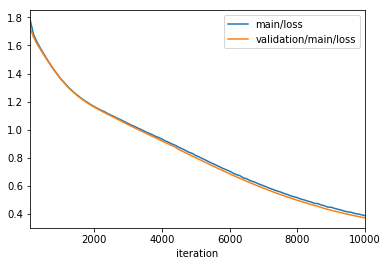

In [29]:
pd.DataFrame(log_df[["main/loss", "validation/main/loss"]].values, columns=["main/loss", "validation/main/loss"], index=log_df["iteration"]).plot()

無事lossの値が下がっていっていますね！

## 性能評価

それでは前章と同様に、性能評価を行いましょう。

In [30]:
from sklearn.metrics import classification_report

In [31]:
y = model(test_X_scale)

In [32]:
pred = np.argmax(y.data, axis=1)

In [33]:
print(classification_report(test_Y, pred))

             precision    recall  f1-score   support

          0       0.94      0.96      0.95       496
          1       0.93      0.56      0.70       491
          2       0.70      0.98      0.82       532
          3       0.93      0.94      0.94       471
          4       0.99      0.96      0.98       537
          5       0.92      0.88      0.90       420

avg / total       0.90      0.88      0.88      2947



In [34]:
pd.crosstab(test_Y, pred)

col_0,0,1,2,3,4,5
row_0,,,,,,
0,475,0,0,1,0,20
1,0,275,210,1,5,0
2,0,10,522,0,0,0
3,11,0,1,445,0,14
4,0,10,9,0,518,0
5,22,0,0,29,0,369


前章よりかなり性能が高くなりましたね。これは乱数の出方が異なるためだと思われます。今回は小さい反復回数で止めていますので、学習の際にどのような乱数が割り振られるかでかなり結果がぶれることはあり得ます。